# Project 1 — Berry–Esseen Rate for Fixed Degree _d_

Empirical confirmation that the overlap  
$$
X_N := \sqrt{N}\,\langle q, u_2\rangle
$$
between a fixed test vector $q\perp\mathbf 1$ and the second eigenvector $u_2$ of a **random $d$-regular graph** converges to 𝒩(0, 1) at the **optimal Berry–Esseen rate**
$$
\sup_x \bigl|\mathbb P(X_N\le x)-\Phi(x)\bigr| \;=\; \Theta\!\bigl(N^{-1/6}\bigr),
$$
as established in Nagel (2025) and Huang–Yau (2023).

**Credits**: This notebook was written by [Hershraj Niranjani](https://hershrajn.com)

---

## Experimental Design

| Stage | What we do | Key parameters |
|-------|------------|----------------|
| **Graph generation** | Build $M \approx 5,000$ simple $d$‑regular graphs for every $(N, d)$. | $d \in \{3,5,10,20\};\; N \in \{5\,000, 10\,000, 50\,000, 100\,000\}$; `igraph.Graph.K_Regular`. |
| **Spectral step** | Form the normalised adjacency $\tilde A = A / \sqrt{d-1}$ and extract $u_2$. | `scipy.sparse.linalg.eigsh` |
| **Statistic** | Compute $X_N$ with $q = e_1 - \dfrac{1}{N}\mathbf 1$ (normalised). | Any deterministic $q \perp \mathbf 1$ works. |
| **Distance metric** | Kolmogorov–Smirnov distance $D_N = \sup_x \lvert F_N(x) - \Phi(x) \rvert$. | Use SciPy’s `stats.kstest` or a manual CDF grid. |
| **Rate extraction** | Linear regression of $\log D_N$ on $\log N$. | Slope $\approx -1/6$ corroborates theory. |


In [1]:
# Note: This was ran in a python virtual environment with python version 3.13.5
# Install the necessary dependencies
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import os 
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import re
import scipy.sparse.linalg as spla
from scipy.stats import kstest, norm, gaussian_kde
import pandas as pd
from typing import List, Sequence

RANDOM_SEED = 42 # 42 for reproducibility

BASE = Path(os.path.abspath(''))

FIGURES = BASE / "figures"
FIGURES.mkdir(exist_ok=True) # Ensure that the figures directory exists

DATA = BASE / "data"
DATA.mkdir(exist_ok=True) # Ensure that the data directory exists


NUM_GRAPHS_TO_LOAD = 3_500 # Number of graphs to load in per (n, d) configuration

print("Setup complete.")

/Users/hershraj.niranjani/Documents/GitHub/randomgraphs-universality-bounds/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete.


In [3]:
def load_graphs(file_names: Sequence[str], in_dir: str | Path) -> List[nx.Graph]:
    """Load .npz edge lists (saved by generate_graphs.py) into NetworkX graphs."""
    graphs: List[nx.Graph] = []
    for file_name in file_names:
        file_path = Path(in_dir) / file_name
        data = np.load(file_path)
        edges = data["edges"]          # shape (m, 2), dtype uint32
        g = nx.Graph()
        g.add_edges_from(map(tuple, edges))
        graphs.append(g)
    return graphs

## Run the analysis
Make sure that you have generated the graphs using the `generate_graphs.py` script

In [4]:
BATCH_SIZE         = 1024
N_JOBS             = max(cpu_count() - 1, 1)

def _x_stat_from_file(path: Path, q: np.ndarray) -> float:
    """Load one .npz, build Graph, return X_N."""
    edges = np.load(path)["edges"]
    g = nx.Graph()
    g.add_edges_from(map(tuple, edges))

    n = g.number_of_nodes()
    d = int(2 * g.number_of_edges() / n)

    A = nx.to_scipy_sparse_array(g, dtype=float) / math.sqrt(d - 1)
    vals, vecs = spla.eigsh(A, k=2, which="LM", tol=1e-2)
    u2 = vecs[:, np.argmax(vals) ^ 1]
    return math.sqrt(n) * float(q @ u2)

graph_files = [
    p for d in ("d3", "d5", "d10", "d20") for p in (DATA / d).glob("*.npz")
]

pat_n = re.compile(r"_n(\d+)")
groups: dict[tuple[int, int], list[Path]] = {}

for p in graph_files:
    d = int(p.parent.name[1:].lstrip("d"))          # folder "d5" -> 5
    n = int(pat_n.search(p.stem).group(1))
    groups.setdefault((n, d), []).append(p)

rows = []
for (n, d), paths in sorted(groups.items()):
    paths = paths[:NUM_GRAPHS_TO_LOAD]              # deterministic slice
    q     = np.append([1.0], np.zeros(n - 1)) - 1.0 / n
    q    /= np.linalg.norm(q)

    X_vals = []

    if n > 50_000:
        BATCH_SIZE = 128 # reduce memory usage for large n

    for i in range(0, len(paths), BATCH_SIZE):
        batch = paths[i : i + BATCH_SIZE]
        X_vals += Parallel(
            n_jobs=N_JOBS,
            backend="loky",
            pre_dispatch="2*n_jobs"                 # keeps memory bounded
        )(delayed(_x_stat_from_file)(p, q) for p in batch)

        tqdm.write(f"[{n=}, {d=}] processed {i + len(batch):,}/{len(paths):,}")

    D_n, _ = kstest(X_vals, norm.cdf)
    var_n    = float(np.var(X_vals, ddof=1))            # unbiased sample variance
    hist_y, hist_x = np.histogram(
        X_vals, bins="auto", density=True
    ) 
    kde_x = np.linspace(min(X_vals), max(X_vals), 200)
    kde_y = gaussian_kde(X_vals)(kde_x)
    rows.append(
        dict(
            n=n,
            d=d,
            D_n=D_n,
            var_n=var_n,
            n_graphs=len(X_vals),
            hist_x=hist_x,           # bin edges  (len = k+1)
            hist_y=hist_y,           # densities  (len = k)
            kde_x=kde_x,           # uncomment if you keep KDE
            kde_y=kde_y,
        )
    )
    tqdm.write(
        f"[n={n:,}, d={d}] D_n={D_n:.4f}, Var={var_n:.3f} from {len(X_vals):,} graphs"
    )

print("All batches done.")
full_df = pd.DataFrame(rows)
full_df.head(50)

[n=1000, d=3] processed 1,024/3,500
[n=1000, d=3] processed 2,048/3,500
[n=1000, d=3] processed 3,072/3,500
[n=1000, d=3] processed 3,500/3,500
[n=1,000, d=3] D_n=0.0108, Var=0.991 from 3,500 graphs
[n=1000, d=5] processed 1,024/3,500
[n=1000, d=5] processed 2,048/3,500
[n=1000, d=5] processed 3,072/3,500
[n=1000, d=5] processed 3,500/3,500
[n=1,000, d=5] D_n=0.0106, Var=0.962 from 3,500 graphs
[n=1000, d=10] processed 1,024/3,500
[n=1000, d=10] processed 2,048/3,500
[n=1000, d=10] processed 3,072/3,500
[n=1000, d=10] processed 3,500/3,500
[n=1,000, d=10] D_n=0.0100, Var=1.000 from 3,500 graphs
[n=1000, d=20] processed 1,024/3,500
[n=1000, d=20] processed 2,048/3,500
[n=1000, d=20] processed 3,072/3,500
[n=1000, d=20] processed 3,500/3,500
[n=1,000, d=20] D_n=0.0178, Var=0.945 from 3,500 graphs
[n=10000, d=3] processed 1,024/3,500
[n=10000, d=3] processed 2,048/3,500
[n=10000, d=3] processed 3,072/3,500
[n=10000, d=3] processed 3,500/3,500
[n=10,000, d=3] D_n=0.0190, Var=1.006 from 3,5

/Users/hershraj.niranjani/Documents/GitHub/randomgraphs-universality-bounds/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[n=100000, d=3] processed 128/3,500
[n=100000, d=3] processed 256/3,500
[n=100000, d=3] processed 384/3,500
[n=100000, d=3] processed 512/3,500
[n=100000, d=3] processed 640/3,500
[n=100000, d=3] processed 768/3,500
[n=100000, d=3] processed 896/3,500
[n=100000, d=3] processed 1,024/3,500
[n=100000, d=3] processed 1,152/3,500
[n=100000, d=3] processed 1,280/3,500
[n=100000, d=3] processed 1,408/3,500
[n=100000, d=3] processed 1,536/3,500
[n=100000, d=3] processed 1,664/3,500
[n=100000, d=3] processed 1,792/3,500
[n=100000, d=3] processed 1,920/3,500
[n=100000, d=3] processed 2,048/3,500
[n=100000, d=3] processed 2,176/3,500
[n=100000, d=3] processed 2,304/3,500
[n=100000, d=3] processed 2,432/3,500
[n=100000, d=3] processed 2,560/3,500
[n=100000, d=3] processed 2,688/3,500
[n=100000, d=3] processed 2,816/3,500
[n=100000, d=3] processed 2,944/3,500
[n=100000, d=3] processed 3,072/3,500
[n=100000, d=3] processed 3,200/3,500
[n=100000, d=3] processed 3,328/3,500
[n=100000, d=3] processed 

Python(9859) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[n=1000000, d=10] processed 3,072/3,500
[n=1000000, d=10] processed 3,200/3,500


Python(16124) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[n=1000000, d=10] processed 3,328/3,500
[n=1000000, d=10] processed 3,456/3,500


Python(19583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(19698) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[n=1000000, d=10] processed 3,500/3,500
[n=1,000,000, d=10] D_n=0.0119, Var=1.011 from 3,500 graphs


Python(20443) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(23717) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(23909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[n=1000000, d=20] processed 128/3,500


Python(23947) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(23948) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(23949) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(23950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(23951) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(23953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(23998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(24000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(24002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(24003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(24141) Malloc

[n=1000000, d=20] processed 256/3,500


Python(24530) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(24531) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(24534) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(24535) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(24878) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(24897) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(24995) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(24998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[n=1000000, d=20] processed 384/3,500


Python(25026) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(25146) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(25168) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[n=1000000, d=20] processed 512/3,500


Python(25506) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(25616) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[n=1000000, d=20] processed 640/3,500


Python(25803) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(26209) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(26337) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[n=1000000, d=20] processed 768/3,500


Python(26359) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(26360) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(26609) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(26662) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[n=1000000, d=20] processed 896/3,500


Python(26929) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(26935) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[n=1000000, d=20] processed 1,024/3,500
[n=1000000, d=20] processed 1,152/3,500
[n=1000000, d=20] processed 1,280/3,500
[n=1000000, d=20] processed 1,408/3,500


Python(27935) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[n=1000000, d=20] processed 1,536/3,500
[n=1000000, d=20] processed 1,664/3,500
[n=1000000, d=20] processed 1,792/3,500
[n=1000000, d=20] processed 1,920/3,500
[n=1000000, d=20] processed 2,048/3,500
[n=1000000, d=20] processed 2,176/3,500
[n=1000000, d=20] processed 2,304/3,500
[n=1000000, d=20] processed 2,432/3,500
[n=1000000, d=20] processed 2,560/3,500
[n=1000000, d=20] processed 2,688/3,500
[n=1000000, d=20] processed 2,816/3,500
[n=1000000, d=20] processed 2,944/3,500
[n=1000000, d=20] processed 3,072/3,500
[n=1000000, d=20] processed 3,200/3,500
[n=1000000, d=20] processed 3,328/3,500
[n=1000000, d=20] processed 3,456/3,500
[n=1000000, d=20] processed 3,500/3,500
[n=1,000,000, d=20] D_n=0.0138, Var=0.987 from 3,500 graphs
All batches done.


,n,d,D_n,var_n,n_graphs,hist_x,hist_y,kde_x,kde_y
0,1000,3,0.010784,0.990585,3500,"[-3.535852574760163, -3.3576395347165504, -3.1...","[0.0016032176188923413, 0.0, 0.006412870475569...","[-3.535852574760163, -3.497344229424106, -3.45...","[0.0007966491250332502, 0.0008907473342399248,..."
1,1000,5,0.010566,0.961837,3500,"[-3.704501492771649, -3.5274513039891464, -3.3...","[0.0016137474220107827, 0.0, 0.0, 0.0, 0.0, 0....","[-3.704501492771649, -3.6689135151269245, -3.6...","[0.0005944807189400111, 0.000584392997946901, ..."
2,1000,10,0.010032,0.999913,3500,"[-3.3682556762135167, -3.1898569429922072, -3....","[0.0016015488482188252, 0.0032030976964376586,...","[-3.3682556762135167, -3.331500158313649, -3.2...","[0.0012438677149444644, 0.0014334510527298442,..."
3,1000,20,0.017756,0.945488,3500,"[-3.2850694413725776, -3.112339437450131, -2.9...","[0.0049623275498083316, 0.0049623275498083454,...","[-3.2850694413725776, -3.252953812502575, -3.2...","[0.00240773687613082, 0.0026755434351925303, 0..."
4,10000,3,0.019033,1.006218,3500,"[-3.8257778920761347, -3.6514601733262118, -3....","[0.0016390432812178593, 0.0016390432812178552,...","[-3.8257778920761347, -3.7881112493311764, -3....","[0.0007242928566203808, 0.0007648832832698662,..."
5,10000,5,0.015574,1.036671,3500,"[-3.8534733576390248, -3.676094361314087, -3.4...","[0.0016107560175325963, 0.0016107560175325963,...","[-3.8534733576390248, -3.817819288025972, -3.7...","[0.0008330320245688801, 0.0009140530340777236,..."
6,10000,10,0.019863,0.993272,3500,"[-3.6391947613648625, -3.465857539451502, -3.2...","[0.0016483146698698947, 0.0, 0.003296629339739...","[-3.6391947613648625, -3.600868943454371, -3.5...","[0.000745752963037322, 0.0008162405634177168, ..."
7,10000,20,0.008254,0.992592,3500,"[-4.115203753789178, -3.943653607015646, -3.77...","[0.0033309710436035373, 0.0, 0.0, 0.0, 0.00333...","[-4.115203753789178, -4.07813512910947, -4.041...","[0.00116958644425399, 0.001156772308783586, 0...."
8,100000,3,0.023528,0.991754,3500,"[-3.5284849824548172, -3.3496581770562917, -3....","[0.003195430182601041, 0.0, 0.0015977150913005...","[-3.5284849824548172, -3.4934385231053575, -3....","[0.0011791686121228823, 0.0012638614519178176,..."
9,100000,5,0.010955,1.016596,3500,"[-3.740072352537236, -3.563246966276565, -3.38...","[0.0016157990193393032, 0.0016157990193393032,...","[-3.740072352537236, -3.7063067008894697, -3.6...","[0.0008249254500271441, 0.0008788490701333209,..."


In [5]:
limited_df = full_df[ full_df["d"] < full_df["n"] ** 0.25 ] # Ensure d(N) < N^0.25
res_df = limited_df.copy()

/var/folders/p7/xx7p3bl11gq90gh82svyrzyw0000gp/T/ipykernel_50374/3683162347.py:11: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(xs, ys, 1)


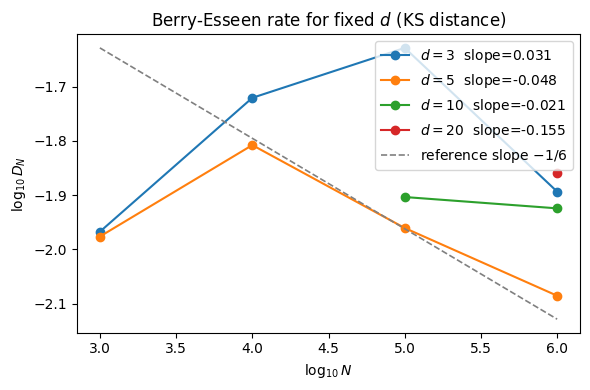

In [6]:


# Visualize the Berry-Esseen rate for fixed d (KS distance)
fig, ax = plt.subplots(figsize=(6, 4))

for d, sub in res_df.groupby("d"):
    sub = sub.sort_values("n")

    xs = np.log10(sub["n"].values)
    ys = np.log10(sub["D_n"].clip(lower=1e-12).values)  # avoid log10(0)

    # least‑squares slope on log‑log scale
    m, b = np.polyfit(xs, ys, 1)
    ax.plot(xs, ys, "o-", label=fr"$d={d}$  slope={m:.3f}")

# reference line with slope −1/6
N_min, N_max = res_df["n"].min(), res_df["n"].max()
ref_x = np.array([N_min, N_max])
y0 = np.log10(res_df["D_n"].max())          # anchor at left edge
ref_y = y0 - (1/6) * (np.log10(ref_x) - np.log10(N_min))
ax.plot(np.log10(ref_x), ref_y, "--", color="gray", lw=1.2,
        label=r"reference slope $-1/6$")

ax.set_xlabel(r"$\log_{10} N$")
ax.set_ylabel(r"$\log_{10} D_N$")
ax.set_title("Berry-Esseen rate for fixed $d$ (KS distance)")
ax.legend()
plt.tight_layout()
plt.show()

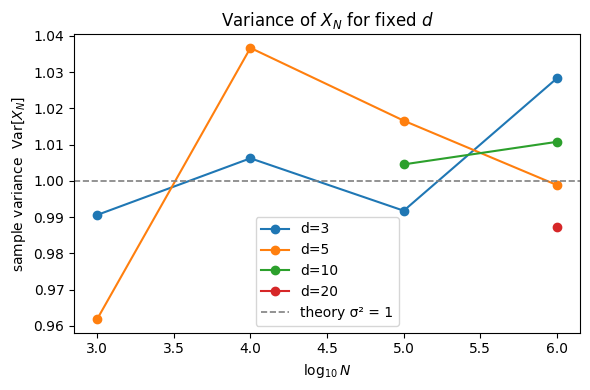

In [7]:
# Visualize the Variance
fig, ax = plt.subplots(figsize=(6, 4))

for d, sub in res_df.groupby("d"):
    sub = sub.sort_values("n")
    ax.plot(
        np.log10(sub["n"]),
        sub["var_n"],
        "o-",
        label=f"d={d}",
    )

ax.axhline(1.0, ls="--", color="gray", lw=1.2, label="theory σ² = 1")
ax.set_xlabel(r"$\log_{10} N$")
ax.set_ylabel(r"sample variance  $\operatorname{Var}[X_N]$")
ax.set_title("Variance of $X_N$ for fixed $d$")
ax.legend()
plt.tight_layout()
plt.show()

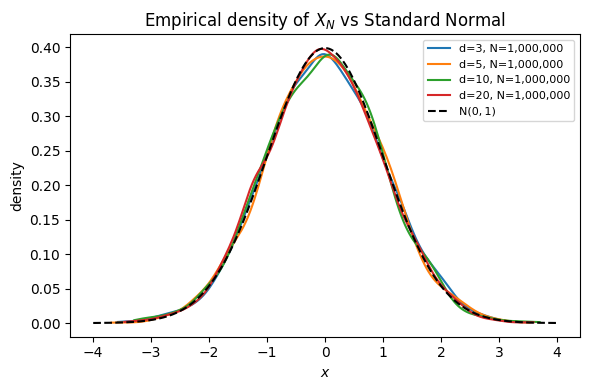

In [8]:
# Visualize the empirical density of X_N vs Standard Normal
fig, ax = plt.subplots(figsize=(6, 4))

for d in sorted(res_df["d"].unique()):
    row = res_df[res_df["d"] == d].sort_values("n").iloc[-1]  # largest N for this d
    ax.plot(
        row["kde_x"], row["kde_y"],
        label=f"d={d}, N={row['n']:,}"
    )

# standard normal pdf for reference
x_grid = np.linspace(-4, 4, 400)
ax.plot(x_grid, norm.pdf(x_grid), "k--", lw=1.5, label="N(0, 1)")

ax.set_xlabel(r"$x$")
ax.set_ylabel("density")
ax.set_title("Empirical density of $X_N$ vs Standard Normal")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Project 2 — Berry–Esseen Rate in the Sparse‑Growing‑Degree Regime

We now let the degree grow slowly with graph size,  
$$
d = d(N) \;\le\; N^{1/4},
$$
and test the refined prediction (Nagel 2025; Huang–Yau 2023) that the **rescaled KS error**

$$
\tilde D_N \;=\; \frac{D_N}{\sqrt{d}}
$$

still obeys the optimal rate  

$$
\tilde D_N \;=\; \Theta\!\bigl(N^{-1/6}\bigr).
$$

Equivalently,

$$
\sup_x \Bigl|\,\mathbb P\!\bigl(X_N \le x\bigr) - \Phi(x)\Bigr|
\;=\;
\Theta\!\bigl(\sqrt{d}\,N^{-1/6}\bigr),
\qquad
X_N \;=\; \sqrt{N}\,\langle q, u_2\rangle.
$$

---

## Experimental Design

| Stage | What we do | Key parameters |
|-------|------------|----------------|
| **Graph generation** | Build simple $d(N)$‑regular graphs with degrees that scale as powers of $N$. | $d(N) \in \{N^{0.00},\, N^{0.10},\, N^{0.25}\}$; &nbsp;$N \in \{5\,000,\;10\,000,\;20\,000,\;40\,000\}$; &nbsp;≈ 50 k graphs per $(N,d)$. |
| **Spectral step** | Form the normalised adjacency $\tilde A = A / \sqrt{d-1}$ and extract $u_2$. | `scipy.sparse.linalg.eigsh` |
| **Statistic** | $X_N = \sqrt{N}\,\langle q, u_2\rangle$ with $q = e_1 - \tfrac1N\mathbf 1$ (normalised). | Same deterministic $q \perp \mathbf 1$ as in Project 1. |
| **Distance metric** | $\tilde D_N = D_N / \sqrt{d}$ where $D_N$ is the KS distance between $X_N$ and $\mathcal N(0,1)$. | `scipy.stats.kstest` |
| **Rate extraction** | Regress $\log_{10}\tilde D_N$ on $\log_{10}N$. | Slope $\approx -1/6$ confirms universality after the $\sqrt{d}$ factor. |


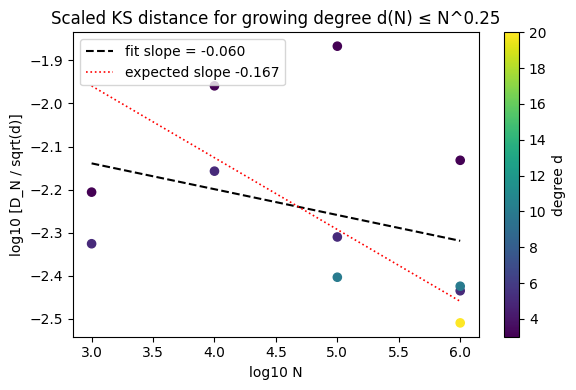

In [9]:
# Visualize the scaled KS distance for growing degree d(N) ≤ N^0.25
fig, ax = plt.subplots(figsize=(6, 4))

# points: all (n,d) pairs, colour‑by‑d for readability
scatter = ax.scatter(
    np.log10(limited_df["n"]),
    np.log10(limited_df["D_n"] / np.sqrt(limited_df["d"])),
    c=limited_df["d"], cmap="viridis", s=35
)

# global least‑squares slope in log–log space
xs = np.log10(limited_df["n"].values)
ys = np.log10(limited_df["D_n"].values / np.sqrt(limited_df["d"].values))
m, b = np.polyfit(xs, ys, 1)
ax.plot(xs, m * xs + b, "k--", lw=1.5, label=f"fit slope = {m:.3f}")

# reference – theoretical slope −1/6
N_min, N_max = limited_df["n"].min(), limited_df["n"].max()
ref_x = np.array([N_min, N_max])
ref_y = b - (1 / 6) * (np.log10(ref_x) - np.log10(N_min))
ax.plot(np.log10(ref_x), ref_y, "r:", lw=1.2, label=f"expected slope {(-1 / 6):.3f}")

ax.set_xlabel("log10 N")
ax.set_ylabel("log10 [D_N / sqrt(d)]")
ax.set_title("Scaled KS distance for growing degree d(N) ≤ N^0.25")
ax.legend()
cbar = plt.colorbar(scatter, ax=ax, label="degree d")
plt.tight_layout()
plt.show()

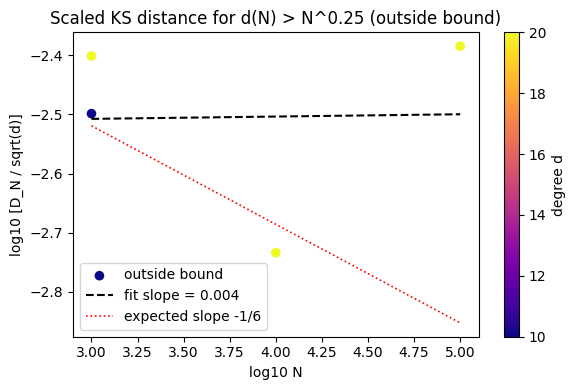

In [10]:
# See how this looks for points not covered by the bound d(N) ≤ N^0.25
# ── Points with d(N) > N^0.25  ──────────────────────────────────────────────
outside_df = full_df[full_df["d"] > full_df["n"] ** 0.25]

fig, ax = plt.subplots(figsize=(6, 4))

# scatter: log‑log of scaled KS distance, colour by degree
scatter = ax.scatter(
    np.log10(outside_df["n"]),
    np.log10(outside_df["D_n"] / np.sqrt(outside_df["d"])),
    c=outside_df["d"],
    cmap="plasma",
    s=35,
    marker="o",
    label="outside bound"
)

# least‑squares slope for these out‑of‑bound points
xs = np.log10(outside_df["n"].values)
ys = np.log10(outside_df["D_n"].values / np.sqrt(outside_df["d"].values))
m, b = np.polyfit(xs, ys, 1)
ax.plot(xs, m * xs + b, "k--", lw=1.5, label=f"fit slope = {m:.3f}")

# theoretical reference: slope −1/6 anchored at smallest N
N_min, N_max = outside_df["n"].min(), outside_df["n"].max()
ref_x = np.array([N_min, N_max])
ref_y = b - (1 / 6) * (np.log10(ref_x) - np.log10(N_min))
ax.plot(np.log10(ref_x), ref_y, "r:", lw=1.2, label="expected slope -1/6")

ax.set_xlabel("log10 N")
ax.set_ylabel("log10 [D_N / sqrt(d)]")
ax.set_title("Scaled KS distance for d(N) > N^0.25 (outside bound)")
ax.legend()
plt.colorbar(scatter, ax=ax, label="degree d")
plt.tight_layout()
plt.show()
